CODE POUR CONVERTIR JSON EN MASKS

In [3]:
import json
import numpy as np
from PIL import Image, ImageDraw
import os


In [41]:
import json
import numpy as np
from PIL import Image, ImageDraw
import os

# Charger le fichier JSON
json_path = "./UNET/label_k500.json"
with open(json_path, 'r') as f:
    data = json.load(f)

# Chemin pour enregistrer les masques générés
output_dir = "./UNET/NEW/MASK/MASK_500"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dimensions des images (par défaut, remplacez si nécessaire)
width = 1250  # Remplacez par la largeur réelle de vos images
height = 1250  # Remplacez par la hauteur réelle de vos images

# Génération des masques pour chaque image
for image_filename, image_data in data.items():
    mask = Image.new("L", (width, height), 0)  # Créer un masque noir
    draw = ImageDraw.Draw(mask)

    print(f"Traitement de l'image : {image_filename}")

    for region in image_data['regions'].values():
        points_x = region['shape_attributes']['all_points_x']
        points_y = region['shape_attributes']['all_points_y']
        polygon = [(x, y) for x, y in zip(points_x, points_y)]

        # Debugging : Afficher les coordonnées du polygone
        print(f"Polygone : {polygon}")

        # Dessiner le polygone sur le masque
        draw.polygon(polygon, outline=255, fill=255)

    # Sauvegarder le masque
    mask_filename = os.path.splitext(image_filename)[0] + "_mask.png"
    mask.save(os.path.join(output_dir, mask_filename))

print(f"Masques générés et sauvegardés dans {output_dir}")


Traitement de l'image : 0402.png
Polygone : [(226.28571428571428, 293.1428571428571), (240, 286.2857142857143), (257.1428571428571, 276), (274.2857142857143, 267.4285714285714), (293.1428571428571, 262.2857142857143), (312, 257.1428571428571), (332.57142857142856, 248.57142857142856), (351.4285714285714, 243.42857142857142), (373.71428571428567, 229.7142857142857), (392.57142857142856, 224.57142857142856), (409.71428571428567, 216), (428.57142857142856, 209.14285714285714), (450.85714285714283, 198.85714285714283), (471.4285714285714, 190.28571428571428), (502.2857142857143, 181.7142857142857), (517.7142857142857, 178.28571428571428), (552, 176.57142857142856), (588, 176.57142857142856), (615.4285714285714, 176.57142857142856), (630.8571428571428, 176.57142857142856), (656.5714285714286, 176.57142857142856), (677.1428571428571, 174.85714285714286), (697.7142857142857, 174.85714285714286), (716.5714285714286, 180), (740.5714285714286, 192), (771.4285714285713, 204), (800.5714285714286, 

TEST RESEAU DE NEURONNES AVEC IMAGES SIMPLES

In [3]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model

# Chemins vers vos images et masques
image_path = './imgtest/'
mask_path = './MASKS_CARRE/'

# Paramètres de l'image
img_height, img_width = 512, 512

def load_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []
    
    for filename in os.listdir(image_dir):
        img = load_img(os.path.join(image_dir, filename), target_size=(img_height, img_width))
        img = img_to_array(img) / 255.0  # Normalisation de l'image
        images.append(img)
        
        mask_filename = os.path.splitext(filename)[0] + "_mask.png"
        mask = load_img(os.path.join(mask_dir, mask_filename), color_mode="grayscale", target_size=(img_height, img_width))
        mask = img_to_array(mask) / 255.0  # Normalisation du masque pour être entre 0 et 1
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Charger les images et les masques
images, masks = load_images_and_masks(image_path, mask_path)

# Fonction pour construire le modèle U-Net
def unet_model(input_size=(img_height, img_width, 3)):
    inputs = Input(input_size)
    
    # Encodeur
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Décodeur
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Créer le modèle
model = unet_model()

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
model.fit(images, masks, batch_size=8, epochs=50, validation_split=0.1)

# Sauvegarder le modèle
model.save('unet_model.h5')


Epoch 1/50


In [4]:
from keras.models import load_model

# Charger le modèle U-Net sauvegardé
model = load_model('unet_model.h5')


In [2]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de l'image (doivent correspondre à ceux utilisés pour l'entraînement)
img_height, img_width = 256, 256

# Chemin vers l'image de test
test_image_path = './imgvalidation/11.png'

# Charger et prétraiter l'image de test
test_img = load_img(test_image_path, target_size=(img_height, img_width))
test_img = img_to_array(test_img) / 255.0  # Normalisation
test_img = np.expand_dims(test_img, axis=0)  # Ajouter une dimension pour le batch


In [5]:
# Prédire le masque pour l'image de test
predicted_mask = model.predict(test_img)

# Convertir la prédiction en masque binaire (0 ou 1)
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

# Si vous voulez visualiser le masque, il faut enlever la dimension du batch
predicted_mask = np.squeeze(predicted_mask)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


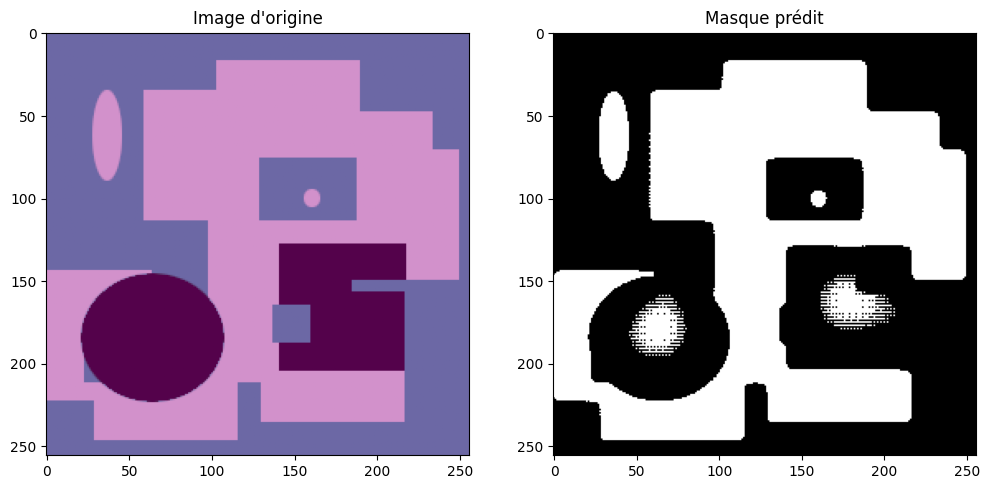

In [6]:
# Afficher l'image d'origine et le masque prédit
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(test_img))  # Afficher l'image originale
plt.title("Image d'origine")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')  # Afficher le masque prédit
plt.title("Masque prédit")

plt.show()


In [2]:
from PIL import Image

# Convertir le masque prédit en image PIL
predicted_mask_img = Image.fromarray((predicted_mask * 255).astype(np.uint8))

# Sauvegarder l'image du masque prédit
predicted_mask_img.save('chemin/vers/le/fichier_de_sortie.png')


NameError: name 'predicted_mask' is not defined

RESEAU NEURONNE FINAL

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Chemins vers vos images et masques
image_path = './UNET/IMG_SOURCE/IMG_CV'
mask_path = './UNET/MASKS/MSK_CV'

# Paramètres de l'image
img_height, img_width = 256, 256

# Fonction pour charger les images et masques
def load_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []
    
    for filename in os.listdir(image_dir):
        img = load_img(os.path.join(image_dir, filename), target_size=(img_height, img_width))
        img = img_to_array(img) / 255.0  # Normalisation des images
        images.append(img)
        
        mask_filename = os.path.splitext(filename)[0] + ".png"
        mask = load_img(os.path.join(mask_dir, mask_filename), color_mode="grayscale", target_size=(img_height, img_width))
        mask = img_to_array(mask) / 255.0  # Normalisation des masques
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Charger les images et les masques
images, masks = load_images_and_masks(image_path, mask_path)

# Fonction pour construire le modèle U-Net
def unet_model(input_size=(img_height, img_width, 3)):
    inputs = Input(input_size)
    
    # Encodeur
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Décodeur
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Créer le modèle
model = unet_model()

# ---- Partie ajoutée pour la fonction dice_loss ----
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)  # Utilise tf.keras.backend.flatten
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


# Compiler le modèle avec la Dice Loss et Binary Cross-Entropy combinée
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_loss, 'accuracy'])
# --------------------------------------------------

# Chemin pour sauvegarder le meilleur modèle
checkpoint_path = 'best_model.keras'

# Ajouter les callbacks pour EarlyStopping et ModelCheckpoint
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)  # Patience de 5 époques sans amélioration
]

# Entraîner le modèle avec les callbacks
history = model.fit(images, masks, batch_size=16, epochs=20, validation_split=0.2, callbacks=callbacks)

# Charger le meilleur modèle sauvegardé
model.load_weights(checkpoint_path)

# Sauvegarder le modèle final (si besoin)
model.save('MODEL_VAC_final.keras')


In [11]:
from keras.models import load_model

# Charger le modèle U-Net sauvegardé
model = load_model('MODEL_BOON.h5')


In [2]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de l'image (doivent correspondre à ceux utilisés pour l'entraînement)
img_height, img_width = 256, 256

# Chemin vers l'image de test
test_image_path = './img/ROGNE_X/0020.png'

# Charger et prétraiter l'image de test
test_img = load_img(test_image_path, target_size=(img_height, img_width))
test_img = img_to_array(test_img) / 255.0  # Normalisation
test_img = np.expand_dims(test_img, axis=0)  # Ajouter une dimension pour le batch


In [5]:
# Prédire le masque pour l'image de test
predicted_mask = model.predict(test_img)

# Convertir la prédiction en masque binaire (0 ou 1)
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

# Si vous voulez visualiser le masque, il faut enlever la dimension du batch
predicted_mask = np.squeeze(predicted_mask)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


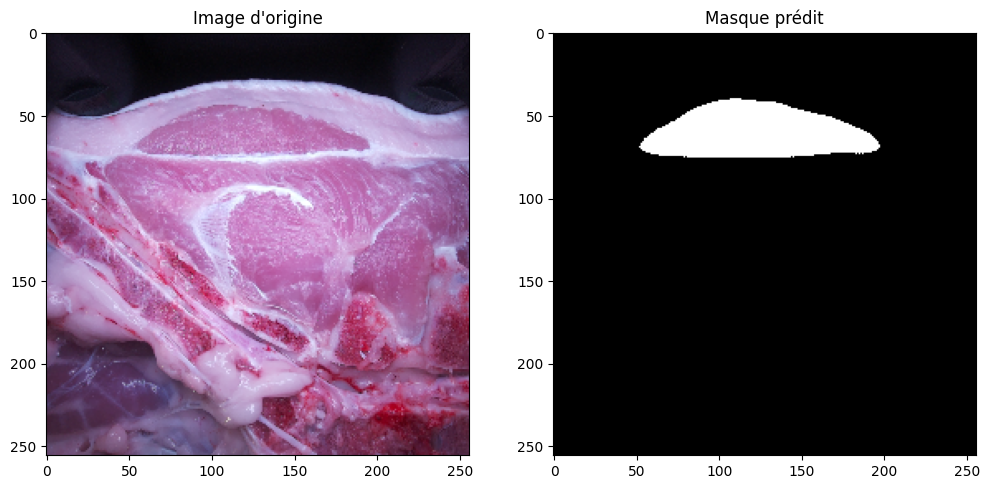

In [6]:
# Afficher l'image d'origine et le masque prédit
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(test_img))  # Afficher l'image originale
plt.title("Image d'origine")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')  # Afficher le masque prédit
plt.title("Masque prédit")

plt.show()


CODE SUPERPOSITION

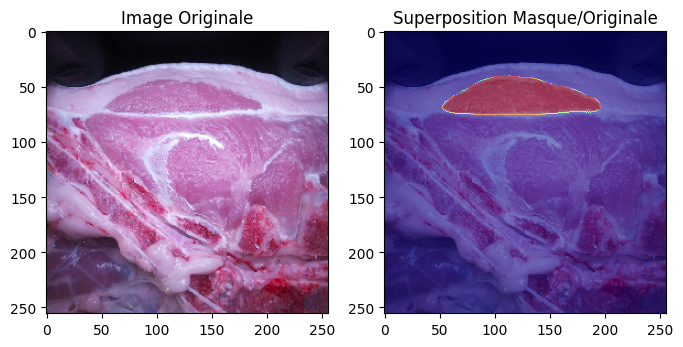

In [7]:
# Affichage avec superposition
plt.figure(figsize=(8, 8))

# Afficher l'image originale
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(test_img))
plt.title('Image Originale')

# Superposer le masque sur l'image originale
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(test_img))  # Image originale en fond
plt.imshow(predicted_mask, cmap='jet', alpha=0.5)  # Masque en semi-transparence (alpha=0.5)
plt.title('Superposition Masque/Originale')

plt.show()


TEST DOSSIER COMPLET

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# Paramètres de l'image (doivent correspondre à ceux utilisés pour l'entraînement)
img_height, img_width = 256, 256

# Dossier contenant les images de test
test_image_dir = './UNET/IMG_SOURCE/PHOTO_K_600_REDIM'

# Dossier où les résultats seront sauvegardés
output_dir = './UNET/IMG_SOURCE/RESULTS_PHOTO_K_600_REDIM/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Liste des fichiers d'images dans le dossier
test_image_files = [f for f in os.listdir(test_image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Parcourir chaque fichier image dans le dossier
for image_file in test_image_files:
    # Chemin complet de l'image
    image_path = os.path.join(test_image_dir, image_file)
    
    # Charger et prétraiter l'image de test
    test_img = load_img(image_path, target_size=(img_height, img_width))
    test_img_array = img_to_array(test_img) / 255.0  # Normalisation
    test_img_array = np.expand_dims(test_img_array, axis=0)  # Ajouter une dimension pour le batch
    
    # Prédire le masque pour l'image de test
    predicted_mask = model.predict(test_img_array)
    
    # Convertir la prédiction en masque binaire (0 ou 1)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    
    # Supprimer la dimension du batch
    predicted_mask = np.squeeze(predicted_mask)
    
    # Créer une figure pour l'affichage
    plt.figure(figsize=(8, 8))
    
    # Afficher l'image originale
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(test_img_array))
    plt.title(f'Image Originale: {image_file}')
    
    # Superposer le masque sur l'image originale
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(test_img_array))  # Image originale en fond
    plt.imshow(predicted_mask, cmap='jet', alpha=0.5)  # Masque en semi-transparence
    plt.title(f'Superposition Masque: {image_file}')
    
    # Sauvegarder la figure dans le dossier de résultats
    output_path = os.path.join(output_dir, f'{os.path.splitext(image_file)[0]}_overlay.png')
    plt.savefig(output_path)  # Sauvegarder la figure dans le fichier
    
    # Fermer la figure pour libérer la mémoire
    plt.close()

print(f"Résultats sauvegardés dans {output_dir}")


RENOMMER FICHIERS

In [ ]:
import os

def renommer_fichiers(dossier, nom_base, extension):
    # Extraire le numéro initial du nom de base
    numero_initial = int(''.join(filter(str.isdigit, nom_base)))
    
    # Récupérer la liste des fichiers dans le dossier
    fichiers = os.listdir(dossier)
    
    # Trier les fichiers par ordre alphabétique
    fichiers.sort()

    # Renommer chaque fichier en suivant le format du nom de base
    for i, fichier in enumerate(fichiers):
        # Extraire l'extension du fichier
        nom_fichier, ext = os.path.splitext(fichier)
        
        # Renommer uniquement si l'extension correspond
        if ext == extension:
            nouveau_nom = f"{str(numero_initial + i).zfill(4)}{extension}"
            ancien_chemin = os.path.join(dossier, fichier)
            nouveau_chemin = os.path.join(dossier, nouveau_nom)
            
            os.rename(ancien_chemin, nouveau_chemin)
            print(f"Renommé: {ancien_chemin} -> {nouveau_chemin}")

# Exemple d'utilisation
dossier = "./UNET/NEW/MASK/MASK_TOTAL"  # Remplace par le chemin du dossier
nom_base = "0001.png"  # Nom de base à partir duquel incrémenter
extension = ".png"  # Extension des fichiers à renommer

renommer_fichiers(dossier, nom_base, extension)


AUGMENTATION DES DONNEES

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img, save_img

# Chemins vers vos images et masques
image_path = './UNET/NEW/IMG/TOTAL_REDIM'
mask_path = './UNET/NEW/MASK/MASK_TOTAL_REDIM'

# Chemins pour sauvegarder les images et masques augmentés
aug_image_path = './UNET/NEW/IMG/TOTAL_REDIM_AUG'
aug_mask_path = './UNET/NEW/MASK/MASK_TOTAL_REDIM_AUG'

# Paramètres de l'image
img_height, img_width = 256, 256

# Créer une instance d'augmentation de données
data_gen_args = dict(rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

# Générateur d'images et de masques
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Fonction pour charger les images et masques
def load_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []
    
    for filename in os.listdir(image_dir):
        img = load_img(os.path.join(image_dir, filename), target_size=(img_height, img_width))
        img = img_to_array(img) / 255.0  # Normalisation des images
        images.append(img)
        
        mask_filename = os.path.splitext(filename)[0] + ".png"
        mask = load_img(os.path.join(mask_dir, mask_filename), color_mode="grayscale", target_size=(img_height, img_width))
        mask = img_to_array(mask) / 255.0  # Normalisation des masques
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Charger les images et masques
images, masks = load_images_and_masks(image_path, mask_path)

# Vérifier que les dossiers de sortie existent, sinon les créer
os.makedirs(aug_image_path, exist_ok=True)
os.makedirs(aug_mask_path, exist_ok=True)

# Préparer les générateurs synchronisés
seed = 1  # Utiliser le même seed pour les deux générateurs
batch_size = 1  # Peut être ajusté

image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed, save_to_dir=aug_image_path, save_prefix='aug_img', save_format='png')
mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed, save_to_dir=aug_mask_path, save_prefix='aug_mask', save_format='png')

# Générateur combiné pour synchroniser les images et les masques
train_generator = zip(image_generator, mask_generator)

# Nombre d'images à générer
num_augmented_images = 5000  # Ajustez ce nombre pour créer plus ou moins d'augmentations

# Générer et sauvegarder les images augmentées
for i in range(num_augmented_images):
    img, mask = next(train_generator)  # Obtenir la prochaine paire image/masque augmentée
    print(f'Image et masque augmentés {i+1}/{num_augmented_images} générés.')


CODE COORDONNEES DETECTION GLUTEUS

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Paramètres de l'image (doivent correspondre à ceux utilisés pour l'entraînement)
img_height, img_width = 256, 256

# Chemin du dossier contenant les images
input_image_dir = './UNET/IMG_SOURCE/IMG_X/'

# Dossier où les résultats seront sauvegardés
output_dir = './UNET/RESULT_COORD_X/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Liste des fichiers d'images dans le dossier
image_files = [f for f in os.listdir(input_image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Parcourir chaque fichier image dans le dossier
for image_file in image_files:
    # Chemin complet de l'image
    image_path = os.path.join(input_image_dir, image_file)
    
    # Charger et prétraiter l'image de test
    test_img = load_img(image_path, target_size=(img_height, img_width))
    test_img_array = img_to_array(test_img) / 255.0  # Normalisation
    test_img_array = np.expand_dims(test_img_array, axis=0)  # Ajouter une dimension pour le batch
    
    # Prédire le masque pour l'image de test
    predicted_mask = model.predict(test_img_array)
    
    # Convertir la prédiction en masque binaire (0 ou 1)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    predicted_mask = np.squeeze(predicted_mask)  # Supprimer la dimension du batch
    
    # Trouver les indices des pixels où l'objet est présent (valeurs de 1 dans le masque)
    object_pixels = np.where(predicted_mask == 1)
    
    if len(object_pixels[0]) > 0:  # Si des pixels de l'objet sont détectés
        # Récupérer les coordonnées xmin, xmax
        xmin = np.min(object_pixels[1])  # Le minimum des coordonnées x
        xmax = np.max(object_pixels[1])  # Le maximum des coordonnées x

        # Trouver les y correspondants aux xmin et xmax
        y_for_xmin = object_pixels[0][np.argmin(object_pixels[1])]  # y correspondant à xmin
        y_for_xmax = object_pixels[0][np.argmax(object_pixels[1])]  # y correspondant à xmax

        # Afficher les coordonnées
        print(f"Image : {image_file}, xmin={xmin}, y_for_xmin={y_for_xmin}, xmax={xmax}, y_for_xmax={y_for_xmax}")

        # Visualiser les points xmin et xmax sur l'image
        plt.imshow(np.squeeze(test_img_array))  # Afficher l'image originale en fond
        plt.scatter(xmin, y_for_xmin, color='red', label='xmin', s=10)  # Point rouge pour xmin
        plt.scatter(xmax, y_for_xmax, color='blue', label='xmax', s=10)  # Point bleu pour xmax
        plt.legend()
        plt.title(f'Image : {image_file} avec Points pour xmin et xmax')

        # Sauvegarder le résultat dans le dossier de sortie
        output_path = os.path.join(output_dir, f'{os.path.splitext(image_file)[0]}_result.png')
        plt.savefig(output_path)
        plt.close()  # Fermer la figure pour libérer la mémoire
    else:
        print(f"Aucun objet détecté dans l'image {image_file}")

print(f"Tous les résultats ont été sauvegardés dans le dossier {output_dir}")


CODE POUR DESSINER PARTIE SUP GLUTEUS DOSSIER

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Paramètres de l'image (doivent correspondre à ceux utilisés pour l'entraînement)
img_height, img_width = 256, 256

# Chemin du dossier contenant les images
input_image_dir = './UNET/IMG_SOURCE/PHOTO_K_600_REDIM'

# Dossier où les résultats seront sauvegardés
output_dir = './UNET/RESULTATS_LIGNE/PHOTO_K_600_REDIM/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Liste des fichiers d'images dans le dossier
image_files = [f for f in os.listdir(input_image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Parcourir chaque fichier image dans le dossier
for image_file in image_files:
    # Chemin complet de l'image
    image_path = os.path.join(input_image_dir, image_file)
    
    # Charger et prétraiter l'image de test
    test_img = load_img(image_path, target_size=(img_height, img_width))
    test_img_array = img_to_array(test_img) / 255.0  # Normalisation
    test_img_array = np.expand_dims(test_img_array, axis=0)  # Ajouter une dimension pour le batch
    
    # Prédire le masque pour l'image de test
    predicted_mask = model.predict(test_img_array)
    
    # Convertir la prédiction en masque binaire (0 ou 1)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    predicted_mask = np.squeeze(predicted_mask)  # Supprimer la dimension du batch
    
    # Trouver les indices des pixels où l'objet est présent (valeurs de 1 dans le masque)
    object_pixels = np.where(predicted_mask == 1)
    
    if len(object_pixels[0]) > 0:  # Si des pixels de l'objet sont détectés
        # Récupérer les coordonnées xmin, xmax
        xmin = np.min(object_pixels[1])  # Le minimum des coordonnées x
        xmax = np.max(object_pixels[1])  # Le maximum des coordonnées x

        # Trouver les y min correspondant à chaque x entre xmin et xmax (limite inférieure)
        for x in range(xmin, xmax + 1):
            y_values = object_pixels[0][object_pixels[1] == x]  # Obtenir tous les y pour un x donné
            if len(y_values) > 0:  # S'assurer qu'il y a des pixels pour ce x
                y_min = np.min(y_values)  # Le y min pour ce x
                plt.scatter(x, y_min, color='green', s=0.1)  # Tracer les points verts pour le y min

        # Afficher les coordonnées
        print(f"Image : {image_file}, xmin={xmin}, xmax={xmax}")

        # Visualiser les points xmin et xmax sur l'image
        plt.imshow(np.squeeze(test_img_array))  # Afficher l'image originale en fond
        plt.scatter(xmin, np.min(object_pixels[0][object_pixels[1] == xmin]), color='red', label='xmin', s=10)  # Point rouge pour xmin
        plt.scatter(xmax, np.min(object_pixels[0][object_pixels[1] == xmax]), color='blue', label='xmax', s=10)  # Point bleu pour xmax
        plt.legend()
        plt.title(f'Image : {image_file} avec Limite Inférieure (xmin à xmax)')

        # Sauvegarder le résultat dans le dossier de sortie
        output_path = os.path.join(output_dir, f'{os.path.splitext(image_file)[0]}_result.png')
        plt.savefig(output_path)
        plt.close()  # Fermer la figure pour libérer la mémoire
    else:
        print(f"Aucun objet détecté dans l'image {image_file}")

print(f"Tous les résultats ont été sauvegardés dans le dossier {output_dir}")


CODE POUR DESSINER PARTIE SUP GLUTEUS IMAGE SIMPLE

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image : ./UNET/IMG_SOURCE/PHOTO_K_600_REDIM/0594.png, xmin=33, xmax=212, ymin=[76], ymax=[66]


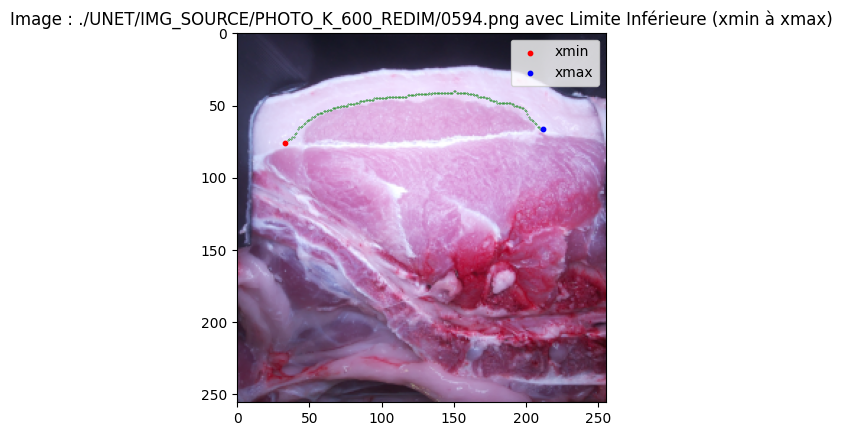

In [22]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Paramètres de l'image (doivent correspondre à ceux utilisés pour l'entraînement)
img_height, img_width = 256, 256



# Chemin complet de l'image
image_path ='./UNET/IMG_SOURCE/PHOTO_K_600_REDIM/0594.png'
    
# Charger et prétraiter l'image de test
test_img = load_img(image_path, target_size=(img_height, img_width))
test_img_array = img_to_array(test_img) / 255.0  # Normalisation
test_img_array = np.expand_dims(test_img_array, axis=0)  # Ajouter une dimension pour le batch
    
# Prédire le masque pour l'image de test
predicted_mask = model.predict(test_img_array)
    
# Convertir la prédiction en masque binaire (0 ou 1)
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
predicted_mask = np.squeeze(predicted_mask)  # Supprimer la dimension du batch
    
# Trouver les indices des pixels où l'objet est présent (valeurs de 1 dans le masque)
object_pixels = np.where(predicted_mask == 1)
    
if len(object_pixels[0]) > 0:  # Si des pixels de l'objet sont détectés
    # Récupérer les coordonnées xmin, xmax
    xmin = np.min(object_pixels[1])  # Le minimum des coordonnées x
    xmax = np.max(object_pixels[1])  # Le maximum des coordonnées x
    
    ymin = y_val = object_pixels[0][object_pixels[1] == xmin]  # Obtenir tous les y pour un x donné
    ymax = y_val2 = object_pixels[0][object_pixels[1] == xmax]  # Obtenir tous les y pour un x donné
    
    
    # Trouver les y min correspondant à chaque x entre xmin et xmax (limite inférieure)
    for x in range(xmin, xmax + 1):
        y_values = object_pixels[0][object_pixels[1] == x]  # Obtenir tous les y pour un x donné
        if len(y_values) > 0:  # S'assurer qu'il y a des pixels pour ce x
            y_min = np.min(y_values)  # Le y min pour ce x
            plt.scatter(x, y_min, color='green', s=0.1)  # Tracer les points verts pour le y min

    # Afficher les coordonnées
    print(f"Image : {image_path}, xmin={xmin}, xmax={xmax}, ymin={ymin}, ymax={ymax}")

    # Visualiser les points xmin et xmax sur l'image
    plt.imshow(np.squeeze(test_img_array))  # Afficher l'image originale en fond
    plt.scatter(xmin, np.min(object_pixels[0][object_pixels[1] == xmin]), color='red', label='xmin', s=10)  # Point rouge pour xmin
    plt.scatter(xmax, np.min(object_pixels[0][object_pixels[1] == xmax]), color='blue', label='xmax', s=10)  # Point bleu pour xmax
    plt.legend()
    plt.title(f'Image : {image_path} avec Limite Inférieure (xmin à xmax)')

else:
    print(f"Aucun objet détecté dans l'image {image_path}")




ROGNAGE

In [ ]:
import os
from PIL import Image

def crop_images(input_folder, output_folder, crop_coordinates):
    # Vérifier si le dossier de sortie existe, sinon le créer
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Parcourir toutes les images du dossier d'entrée
    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path)

            # Rogner l'image avec les coordonnées données
            cropped_img = img.crop(crop_coordinates)

            # Enregistrer l'image rognée dans le dossier de sortie
            output_path = os.path.join(output_folder, filename)
            cropped_img.save(output_path)

            print(f'Image {filename} rognée et sauvegardée dans {output_path}')

# Exemple d'utilisation
input_folder = './UNET/IMG_SOURCE/PHOTO_K_600'
output_folder = './UNET/IMG_SOURCE/PHOTO_K_600'
crop_coordinates = (477, 0, 1773, 1296)  # Remplacer avec les coordonnées réelles

crop_images(input_folder, output_folder, crop_coordinates)

In [30]:
import os
import numpy as np
import cv2
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Fonction pour détecter la couche supérieure et inférieure via le modèle U-Net
def detect_fat_layers(model, image_path, img_height=256, img_width=256):
    """
    Utilise le modèle U-Net pour détecter les couches supérieure et inférieure de gras.
    Retourne les pixels où l'objet (gras) est détecté.
    """
    # Charger et prétraiter l'image de test
    test_img = load_img(image_path, target_size=(img_height, img_width))
    test_img_array = img_to_array(test_img) / 255.0  # Normalisation
    test_img_array = np.expand_dims(test_img_array, axis=0)  # Ajouter une dimension pour le batch
    
    # Prédire le masque pour l'image de test
    predicted_mask = model.predict(test_img_array)
    
    # Convertir la prédiction en masque binaire (0 ou 1)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    predicted_mask = np.squeeze(predicted_mask)  # Supprimer la dimension du batch
    
    # Trouver les indices des pixels où l'objet est présent (valeurs de 1 dans le masque)
    object_pixels = np.where(predicted_mask == 1)
    
    return object_pixels

# Calculer l'épaisseur minimale entre les couches supérieure et inférieure
def calculate_min_thickness(object_pixels, xmin, xmax, image):
    """
    Calcule l'épaisseur minimale entre les couches supérieure et inférieure et dessine la ligne en rouge.
    """
    min_thickness = float('inf')  # Initialiser avec une valeur infinie
    min_x, min_y_max, min_y_min = None, None, None  # Pour stocker les coordonnées de l'épaisseur minimale

    for x in range(xmin, xmax + 1):
        # Trouver le y_max (partie supérieure) pour ce x
        y_max_values = object_pixels[0][object_pixels[1] == x]
        if len(y_max_values) > 0:
            y_max = max(y_max_values)  # Le y_max (haut) pour la couche supérieure

            # Trouver le y_min (partie inférieure) pour ce x
            y_min = min(y_max_values)  # Le y_min (bas) pour la couche inférieure

            # Calculer la distance entre y_min et y_max (épaisseur de la couche de gras)
            thickness = y_min - y_max
            if thickness < min_thickness:
                min_thickness = thickness
                min_x, min_y_max, min_y_min = x, y_max, y_min  # Sauvegarder les coordonnées de l'épaisseur minimale

    # Si on a trouvé une épaisseur minimale, tracer une ligne rouge sur l'image
    if min_x is not None and min_y_max is not None and min_y_min is not None:
        cv2.line(image, (min_x, min_y_max), (min_x, min_y_min), (0, 0, 255), 2)  # Ligne rouge pour épaisseur min

    return min_thickness, image

# Charger l'image
image_path = './UNET/IMG_SOURCE/PHOTO_K_600_REDIM/0594.png'
image = cv2.imread(image_path)

# Définir la zone d'intérêt pour la détection des couches
xmin, xmax = 33, 212  # Coordonnées X de la zone
ymin, ymax = 0, 76  # Coordonnées Y de la zone

# Détection des couches supérieure et inférieure avec U-Net
object_pixels = detect_fat_layers(model, image_path)

# Calculer l'épaisseur minimale de gras et dessiner la ligne rouge
min_thickness, result_image = calculate_min_thickness(object_pixels, xmin, xmax, image)

# Afficher le résultat
print(f"L'épaisseur minimale de la couche de gras est : {min_thickness} pixels")

# Visualiser l'image avec la ligne rouge pour l'épaisseur minimale
cv2.imshow('Epaisseur minimale de la couche de gras', result_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Sauvegarder l'image avec la ligne rouge
#cv2.imwrite('resultat_epaisseur_minimale.png', result_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
L'épaisseur minimale de la couche de gras est : -34 pixels


Test

In [34]:
import cv2
import numpy as np

def detect_white_contours(image, xmin, xmax, ymin, ymax):
    """
    Détecte les contours des zones blanches de l'image dans une zone définie.
    Garde uniquement les contours entre x et les coordonnées y min et y max.
    
    image: Image d'entrée (en BGR).
    minX, maxX, minY, maxY: Coordonnées délimitant la zone d'intérêt.

    return: Image avec contours colorés en vert et masque binaire avec contours entre y min et y max.
    """
    # Recadrer l'image sur la zone d'intérêt
    cropped_image = image[ymin:ymax, xmin:xmax]

    # Convertir l'image de BGR à HSV
    hsv_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)

    # Définir une plage de couleur pour le blanc en HSV (très haute luminosité et faible saturation)
    lower_white = np.array([0, 0, 200])  # Borne inférieure (près du blanc)
    upper_white = np.array([180, 55, 255])  # Borne supérieure (blanc pur)

    # Créer un masque pour isoler les zones blanches
    white_mask = cv2.inRange(hsv_image, lower_white, upper_white)

    # Trouver les contours dans le masque
    contours, _ = cv2.findContours(white_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Créer une image de résultat en noir
    result_image = np.zeros_like(cropped_image)

    # Filtrer les contours qui se trouvent entre xmin et xmax, ymin et ymax
    for contour in contours:
        # Extraire les coordonnées x et y de chaque point du contour
        for point in contour:
            x, y = point[0][0], point[0][1]  # x et y des contours détectés
            if xmin <= x <= xmax and ymin <= y <= ymax:
                # Dessiner les contours en vert uniquement dans cette zone
                cv2.drawContours(result_image, [contour], -1, (0, 255, 0), 2)

    # Remettre l'image recadrée avec les contours dans l'image d'origine
    image[ymin:ymax, xmin:xmax] = result_image

    return image, white_mask

# Charger l'image
image = cv2.imread('./UNET/IMG_SOURCE/PHOTO_K_600_REDIM/0594.png')

# Définir la zone d'intérêt (exemple)
xmin, xmax = 33, 212  # Coordonnées X de la zone
ymin, ymax = 0, 76  # Coordonnées Y de la zone

# Détecter les contours des zones blanches uniquement dans la zone définie
contours_image, mask = detect_white_contours(image, xmin, xmax, ymin, ymax)

# Afficher les résultats
cv2.imshow('Contours du blanc dans la zone définie', contours_image)
cv2.imshow('Masque blanc dans la zone définie', mask)

cv2.waitKey(0)
cv2.destroyAllWindows()

# Sauvegarder l'image avec les contours
#cv2.imwrite('resultat_contours_verts.png', contours_image)
